In [69]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage, RemoveMessage
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from typing import List, Dict, Any

from IPython.display import Image, display


In [ ]:
class CalculatorSchema(MessagesState):
    # messages: List[AnyMessage]
    execution_environment: Dict
    summary: str

from langchain_openai import ChatOpenAI

def null_node(state: CalculatorSchema):
    return state

llm = ChatOpenAI(model="gpt-4o")

def summarizer(state: CalculatorSchema):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_summarize(state: CalculatorSchema):
    
    messages = state['messages']
    
    if len(messages) > 10:
        print("Summarizing")
        return "summarizer"
    else:
        print("Not summarizing")
        return END

In [24]:
builder_summ = StateGraph(CalculatorSchema)

builder_summ.add_node("decide_summarizing", null_node)
builder_summ.add_node("summarizing", summarizer)
# builder.add_node("assistant", assistant)


builder_summ.add_edge(START, "decide_summarizing")
builder_summ.add_conditional_edges("decide_summarizing", should_summarize)
builder_summ.add_edge("summarizing", END)

agent = builder_summ.compile()

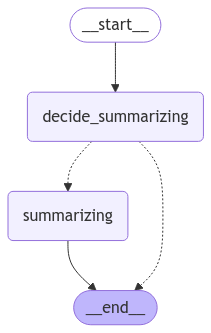

In [4]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Calculator

In [ ]:
# from langchain_openai import ChatOpenAI

from arithmetics import add, subtract, multiply, divide, power, run_code, get_calculator_locals, get_calculator_globals, get_calculator_all, codeExecutor

tools = [add, subtract, multiply, divide, power, run_code, get_calculator_locals, get_calculator_globals, get_calculator_all]

# llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_message = """
"You are a helpful assistant tasked with performing arithmetic operations. 
You can use the following operations: addition, subtraction, multiplication, division, and power. 

You can also run tour own code. You can do so by:

1 - Using 'run_code' 
2 - Then use `print_var` the times you need to get the variable(s) of your interest in order to fulfill the task or the user's request.


As far as now, these are the local variables you can access:

{locals}

And these are the global variables you can access:

{globals}
"""

In [ ]:
def assistant(state: CalculatorSchema):
    
    sys_msg = SystemMessage(content=sys_message.format(locals = codeExecutor.get_locals(), globals = codeExecutor.get_globals()))
    
    return {
       "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
       "execution_environment": get_calculator_all(),
       }
    


In [61]:
# Graph
builder_calc = StateGraph(CalculatorSchema)

builder_calc.add_node("assistant", assistant)
builder_calc.add_node("tools", ToolNode(tools))

builder_calc.add_edge(START, "assistant")
builder_calc.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder_calc.add_edge("tools", "assistant")

calculator_agent = builder_calc.compile()

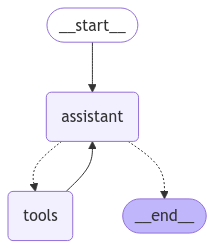

In [62]:
calculator_agent

## Graph composition

In [29]:
from langgraph.checkpoint.memory import MemorySaver

calc_builder = StateGraph(CalculatorSchema)
calc_builder.add_node("calculator", builder_calc.compile())
calc_builder.add_node("summarizer", builder_summ.compile())

calc_builder.add_edge(START, "calculator")
calc_builder.add_edge("calculator", "summarizer")
calc_builder.add_edge("summarizer", END)

memory = MemorySaver()

calc_agent = calc_builder.compile(checkpointer=memory)

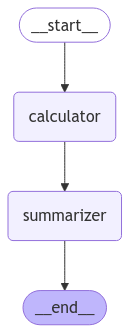

In [10]:
calc_agent

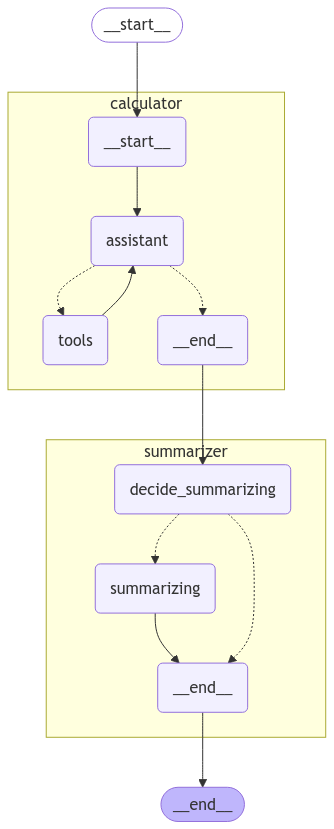

In [11]:
# Setting xray to 1 will show the internal structure of the nested graph
display(Image(calc_agent.get_graph(xray=1).draw_mermaid_png()))

In [30]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [31]:
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [32]:
# Specify an input
messages = [HumanMessage(content="Multiply that by 2.")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_38UsoVBcFwFYkrA5trpbY6Aq)
 Call ID: call_38UsoVBcFwFYkrA5trpbY6Aq
  Args:
    a: 14
    b: 2
================================= Tool Message =================================
Name: multiply

28

================================== Ai Message ==================================

The result of multiplying 14 by 2 is 28.


In [33]:
messages

{'messages': [HumanMessage(content='Multiply that by 2.', additional_kwargs={}, response_metadata={}, id='02bbc6b6-6e84-4c4d-abf8-5a63c164cd71'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_38UsoVBcFwFYkrA5trpbY6Aq', 'function': {'arguments': '{"a":14,"b":2}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 2754, 'total_tokens': 2772, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2688}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-942efbad-77bb-4d56-9b9c-cebfa4fe6282-0', tool_calls=[{'name': 'multiply', 'args': {'a': 14, 'b': 2}, 'id': 'call_38UsoVBcFwFYkrA5trpbY6Aq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2754, 'out

In [39]:
for chunk in calculator_agent.stream({"messages": [HumanMessage(content="Want to know your name")]}, config, stream_mode="updates"):
    chunk['assistant']['messages'][0].pretty_print()

================================== Ai Message ==================================

I am an AI assistant and I don't have a personal name like a human does. However, you can refer to me as "Assistant" or "AI" if you like!


In [40]:
input_message = HumanMessage(content="What's 3 power 4?")   
for event in calculator_agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()

================================ Human Message =================================

What's 3 power 4?
================================ Human Message =================================

What's 3 power 4?
================================== Ai Message ==================================
Tool Calls:
  power (call_jdPvRorht9czDgkhDaaRA0Qn)
 Call ID: call_jdPvRorht9czDgkhDaaRA0Qn
  Args:
    a: 3
    b: 4
================================ Human Message =================================

What's 3 power 4?
================================== Ai Message ==================================
Tool Calls:
  power (call_jdPvRorht9czDgkhDaaRA0Qn)
 Call ID: call_jdPvRorht9czDgkhDaaRA0Qn
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: power

81

================================ Human Message =================================

What's 3 power 4?
================================== Ai Message ==================================
Tool Calls:
  power (ca

In [41]:
# Specify an input
messages = [HumanMessage(content="Tell me the content of your execution environment")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me the content of your execution environment
================================== Ai Message ==================================
Tool Calls:
  get_calculator_all (call_HJuUX9PTsZT9ZTghN0P12Rc0)
 Call ID: call_HJuUX9PTsZT9ZTghN0P12Rc0
  Args:
================================= Tool Message =================================
Name: get_calculator_all

[{"result": "81\n"}, {}]
================================== Ai Message ==================================

The content of the execution environment includes the local variable `result` with a value of 81. There are no additional global variables defined in the current environment.


In [49]:
def node1(state: CalculatorSchema):
    return state

def node2(state: CalculatorSchema):
    return state

null_builder = StateGraph(CalculatorSchema)
null_builder.add_node("node1", node1)
null_builder.add_node("node2", node2)

null_builder.add_edge(START, "node1")
null_builder.add_edge("node1", "node2")
null_builder.add_edge("node2", END)

null_agent = null_builder.compile()

In [50]:
kk_builder = StateGraph(CalculatorSchema)
kk_builder.add_node("summarizer", null_builder.compile())

kk_builder.add_edge(START, "summarizer")
kk_builder.add_edge("summarizer", END)

kk_agent = kk_builder.compile()

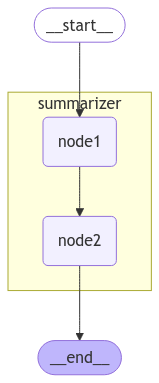

In [51]:
display(Image(kk_agent.get_graph(xray=1).draw_mermaid_png()))

In [65]:
# Graph
builder_calc = StateGraph(CalculatorSchema)

builder_calc.add_node("assistant", assistant)
builder_calc.add_node("tools", ToolNode(tools))
builder_calc.add_node("summarizer", kk_agent)

builder_calc.add_edge(START, "assistant")
builder_calc.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder_calc.add_conditional_edges(
    "assistant",
    should_summarize,
)
builder_calc.add_edge("tools", "assistant")
builder_calc.add_edge("summarizer", END)

calculator_agent = builder_calc.compile()

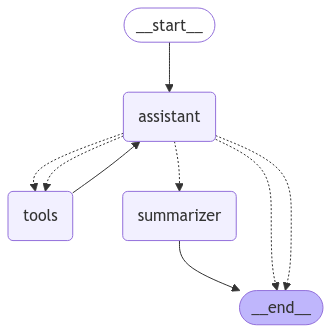

In [66]:
display(Image(calculator_agent.get_graph(xray=1).draw_mermaid_png()))

In [67]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [68]:
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = calculator_agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Not summarizing
Not summarizing
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_fXcos3yolhLm2AuEShCJS0Wf)
 Call ID: call_fXcos3yolhLm2AuEShCJS0Wf
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7

================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
